# bw2-snippets
A compilation of code snippets, useful when using brightway2, the python framework for life cycle assessment, especially when starting

The code snippets are compiled in a jupyter notebook, and described with markdown text and/or in-line comments. 

Future to-do:
- split in several notebooks, per theme / user level
- create a jupyter notebook "extension" to access the code snippets directly in jupyter's gui 

## Starter

### import common libaries

In [ ]:
import brightway2 as bw2
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group

%matplotlib inline

### select existing or create bw2 project

In [ ]:
project_name = 'my_project_name'
if project_name not in bw2.projects:
    bw2.projects.create_project(project_name)
bw2.projects.set_current(project_name)

if "biosphere3" not in bw2.databases:
    bw2.bw2setup()

In [ ]:
pro = 'my_project_name'
bw2.projects.set_current(pro)

### search for activity in database

In [ ]:
db_name = 'use_1_tree-planting' # name of database to search
# search via list comprehension
act = [a for a in bw2.Database(db_name)
       if "keyword to search" in str(a)
       and not "keyword to exclude" in str(a)
       # add more keywords to search/exclude by adding lines below:  and "..." in str(a)
      ] 
act.sort(reverse=True) # optional sorting of list
act

In [ ]:
def searchActivity(ins=[], outs=[], db=''):
    '''
    Usage:
    activities = searchActivity(ins=['lifecycle'], outs=[], db='use_4_filter')
    '''
    return [a for a in bw2.Database(db)
           if all(str_in in str(a) for str_in in ins)
           and all(str_out not in str(a) for str_out in outs)]

### search parameters

In [ ]:
def searchParameters(string):
    '''
    Search for all parameters containing string in their param.name
    For the current project, using ProjectParameter function (get it via: from bw2data.parameters import ProjectParameter 
    
    '''
    wanted = []
    for param in ProjectParameter.select():
        # param.dict = whole dict
        # other attributes of param object: database, code, name, formula, amount
        if str(string) in param.name:
            wanted.append(param.dict)
    return wanted

def getSingleParam(name, silent=False):
    # get individual parameter by name
    p = ProjectParameter.get(ProjectParameter.name == name)
    if not silent:
        print(p.name, p.amount, p.formula)
    return p

### select IPCC and ILCD methods, create list of units with corrected syntax

In [ ]:
IPCC = [method for method in bw2.methods if "IPCC 2013" in str(method) 
        and "GWP 100" in str(method) 
        and "LT" not in str(method)
        and "V1" not in str(method)]
IPCC_unit = [r'kg $CO_2$-eq']

EcoScarEnergy = [method for method in bw2.methods
        if "ecological scarcity" in str(method) 
        and "2013" in str(method)
        and "energy" in str(method)
        and "no LT" not in str(method)]

EcoScarEnergy_unit = [bw2.methods[method]['unit'] for method in EcoScarEnergy]

CExD = [method for method in bw2.methods
        if "cumulative exergy demand" in str(method) ]
CExD_units = [bw2.methods[method]['unit'] for method in CExD]

ILCD = [method for method in bw2.methods if "ILCD 2.0" in str(method) 
        and "LT" not in str(method)
        and "V1" not in str(method)
        and "climate change" not in str(method)] # excluding climate change

ILCD_units = [bw2.methods[method]['unit'] for method in ILCD]
# correct some units, with chemical symbols
ILCD_units[0] = r'mol $H^{+}$-Eq'
ILCD_units[6] = r'kg $U_235$-Eq'
ILCD_units[-5] = r'$m^3$ water'

all_methods= IPCC + ILCD + CExD
all_methods_units= IPCC_unit + ILCD_units + CExD_units

slt = [0, 4, 14, 15]
subset_methods = [all_methods[i] for i in slt]
subset_methods_units = [all_methods_units[i] for i in slt]

### Write new data to a database

In [ ]:
db = bw2.Database(fg_db) # loads the data existing, the new scenario will be pushed to it
data = db.load()
data.update( new_activity ) # only update the key (fg_db, act_code) or create it
db.write(data)

### Function to import LCI of pyrolysis reactor from Excel

In [ ]:
def add_reactors_lci(all_reactors):
    '''
    Parse Inventories from an excel file, and return dictionary
    '''
    new_activity = {}
    fg_db = 'pro_biochar'
    fp = 'lci/LCI_pyrolysis reactors.xlsx'

    for reactor in all_reactors:
        df_lci = pd.read_excel(fp, sheet_name=reactor, usecols='B:G', skiprows=15)

        act_code = 'manufdisposal'+reactor

        plant_activity = {
            'name': 'manufacturing and disposal of pyrolysis reactor '+reactor,
            'code': act_code,
            'unit': 'unit',
            'location':'CH',
            'type': 'process',
            'reference product': 'pyrolysis reactor, manufactured and disposed, '+reactor,
            'comment':'',
            'exchanges':[
                    {'output': (fg_db, act_code), #self tuple
                    'input': (fg_db, act_code), #self tuple
                    'type':'production',
                    'unit':'unit',
                    'amount':1}
            ],
        }

        for index, row in df_lci.iterrows():
            key = eval(row['key'])
            if key[0] == 'biosphere3':
                # add biosphere exchange
                plant_activity['exchanges'].append(
                    {'type': 'biosphere',
                    'name': row['product'],
                    'amount': row['amount'],
                    'unit': row['unit'],
                    'input': eval(row['key']),
                    #'negative': row['negative']
                    } )

            else:
                # add technosphere exchange
                plant_activity['exchanges'].append(
                    {'type': 'technosphere',
                    'name': row['activity'],
                    'amount': row['amount'],
                    'unit': row['unit'],
                    'input': eval(row['key']),
                    #'negative': row['negative']
                    }
                )


        new_activity.update([ ( (fg_db, act_code), plant_activity) ])

    return new_activity

### Export / Import Project Parameters between computers

In [1]:
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group
def ExportProjectParameters(f='ProjectParamExport.xlsx'):
    params = { i:p.dict for i,p in enumerate(ProjectParameter.select() )}
    pd.DataFrame.from_dict(params).to_excel('ProjectParamExport.xlsx')

def LoadProjectParameters(f='ProjectParamExport.xlsx'):
    df = pd.read_excel('ProjectParamExport.xlsx', index_col=0)
    paramDict = df.to_dict(orient='dict')
    paramList = [v for k,v in paramDict.items()]
    bw2.parameters.new_project_parameters(paramList, overwrite=True)
    bw2.parameters.recalculate()

### Reverting dictionaries

In [3]:
## Helping functions
def rev_dict(d):
    '''reverse the k,v of the dictionary'''
    return {v: k for k, v in d.items()}

def reindex_dict(d):
    ''' reindexes a dictionary where the keys are integers, sorted'''
    return {i:k[1] for i,k in enumerate(d.items())}

def readable_dict(d):
    ''' d = dict of format key=interger, value=tuple,activity key'''
    return {k:bw2.get_activity(v)['name'] for k,v in d.items() }


## Contribution analysis - convenient tagging + traverse multiple foreground, with options as in SimaPro

In [ ]:
from __future__ import print_function, unicode_literals
from eight import *

from bw2data import databases, methods, get_activity, Method
from bw2calc import LCA
from collections import defaultdict

def traverse_tagged_databases(
    functional_unit, method, label="tag", default_tag="other", secondary_tags=[],
    fg_databases=None, bio2tech=False, parent4other=False
):

    """
    ESA : allows to perform grouping as in SimaPro 
    
    Traverse a functional unit throughout its foreground database(s) or the 
    
    listed databses in fg_databses, and group impacts by tag label.


    Contribution analysis work by linking impacts to individual activities.

    However, you also might want to group impacts in other ways. For example,

    give individual biosphere exchanges their own grouping, or aggregate two

    activities together.


    Consider this example system, where the letters are the tag labels, and the

    numbers are exchange amounts. The functional unit is one unit of the tree

    root.


    .. image:: images/tagged-traversal.png

       :alt: Example tagged supply chain


    In this supply chain, tags are applied to activities and biosphere exchanges.

    If a biosphere exchange is not tagged, it inherits the tag of its producing

    activity. Similarly, links to other databases are assessed with the usual

    LCA machinery, and the total LCA score is tagged according to its consuming

    activity. If an activity does not have a tag, a default tag is applied.


    We can change our visualization to show the use of the default tags:


    .. image:: images/tagged-traversal-2.png

       :alt: Example tagged supply chain


    And then we can manually calculate the tagged impacts. Normally we would

    need to know the actual biosphere flows and their respective

    characterization factors (CF), but in this example we assume that each

    CF is one. Our result, group by tags, would therefore be:


        * **A**: :math:`6 + 27 = 33`

        * **B**: :math:`30 + 44 = 74`

        * **C**: :math:`5 + 16 + 48 = 69`

        * **D**: :math:`14`


    This function will only traverse the foreground database, i.e. the

    database of the functional unit activity. A functional unit can have

    multiple starting nodes; in this case, all foreground databases are

    traversed.


    Input arguments:

        * ``functional_unit``: A functional unit dictionary, e.g. ``{("foo", "bar"): 42}``.

        * ``method``: A method name, e.g. ``("foo", "bar")``

        * ``label``: The label of the tag classifier. Default is ``"tag"``

        * ``default_tag``: The tag classifier to use if none was given. Default is ``"other"``

        * ``secondary_tags``: List of tuples in the format (secondary_label, secondary_default_tag). Default is empty list.
        
        * ``fg_databases``: a list of foreground databases to be traversed, e.g. ['foreground', 'biomass', 'machinery']
                            It's not recommended to include all databases of a project in the list to be traversed, especially not ecoinvent itself


    Returns:


        Aggregated tags dictionary from ``aggregate_tagged_graph``, and tagged supply chain graph from ``recurse_tagged_database``.


    """

    lca = LCA(functional_unit, method)

    lca.lci(factorize=True)

    lca.lcia()

    method_dict = {o[0]: o[1] for o in Method(method).load()}

    graph = [
        recurse_tagged_database(
            key, amount, method_dict, lca, label, default_tag, secondary_tags, fg_databases, parent4other
        )
        for key, amount in functional_unit.items()
    ]

    return aggregate_tagged_graph(graph, bio2tech), graph


def aggregate_tagged_graph(graph, bio2tech=False,):
    """Aggregate a graph produced by ``recurse_tagged_database`` by the provided tags.

    Outputs a dictionary with keys of tags and numeric values.
    
    If bio2tech is set to True, then biosphere exchanges are added to the tag of the parent activity (instead of direct emissions)

    .. code-block:: python

        {'a tag': summed LCIA scores}

    """

    def recursor(obj, scores):
        scores[obj["tag"]] += obj["impact"]
        if bio2tech:
            for flow in obj["biosphere"]:
                scores[obj["tag"]] += flow["impact"]
        else: # default behavior
            for flow in obj["biosphere"]:
                scores[flow["tag"]] += flow["impact"]
        for exc in obj["technosphere"]:
            scores = recursor(exc, scores)
        return scores

    scores = defaultdict(int)
    for obj in graph:
        scores = recursor(obj, scores)
    return scores


def recurse_tagged_database(
    activity, amount, method_dict, lca, label, default_tag, secondary_tags=[], fg_databases=None, parent4other=False
):

    """Traverse a foreground database and assess activities and biosphere flows by tags.


    Input arguments:


        * ``activity``: Activity tuple or object

        * ``amount``: float

        * ``method_dict``: Dictionary of biosphere flow tuples to CFs, e.g. ``{("biosphere", "foo"): 3}``

        * ``lca``: An ``LCA`` object that is already initialized, i.e. has already calculated LCI and LCIA with same method as in ``method_dict``

        * ``label``: string

        * ``default_tag``: string

        * ``secondary_tags``: List of tuples in the format (secondary_label, secondary_default_tag). Default is empty list.
        
        * ``fg_databases``: a list of foreground databases to be traversed, e.g. ['foreground', 'biomass', 'machinery']
                            It's not recommended to include all databases of a project in the list to be traversed, especially not ecoinvent itself

        * parent4other=False : if True, untagged technosphere exchanges are aggregated with their parent .. become "outside"

  Returns:


    .. code-block:: python


        {

            'activity': activity object,

            'amount': float,

            'tag': string,

            'secondary_tags': [list of strings],

            'impact': float (impact of inputs from outside foreground database),

            'biosphere': [{

                'amount': float,

                'impact': float,

                'tag': string,

                'secondary_tags': [list of strings]

            }],

            'technosphere': [this data structure]

        }


    """

    if isinstance(activity, tuple):
        activity = get_activity(activity)
        
    if fg_databases == None: # then set the list equal to the database of the functional unit 
    
        fg_databases = [activity['database']] # list, single item
    
    elif fg_databases == list(bw2.Database(activity['database']).find_graph_dependents()): 
        # check that the list fg_databases does not include all the databases involved in the FU 
        # (otherwise, it would mean we are likely to have to recurse through ecoinvent... not funny)
        # ideally, should only on first call of recurse_tagged_database
        raise Exception('The list of databases to traverse fg_databases should not be equal to the all databases involved in the project. You risk to attempt to traverse a background database like ecoinvent - it would take too much time')

    inputs = list(activity.technosphere())
    #print('activity', activity['name'])
    #print('inputs', inputs)
    
    production = list(activity.production())
    if len(production) == 1:
        scale = production[0]["amount"]
    elif not production:
        # Assume production amount of 1
        scale = 1
    else:
        raise ValueError("Can't scale by production exchange")

    inside = [exc for exc in inputs if exc["input"][0] in fg_databases] # inside = activities in fg_databases
    #print('inside', inside)
    
    outside = {
        exc["input"]: exc["amount"] / scale * amount
        for exc in inputs
        if exc["input"][0] not in fg_databases ## calculates impacts for activities outside of fg_databases
    } # this is a dict of functional units, ready for lca score calculation

    if outside:

        lca.redo_lcia(outside)

        outside_score = lca.score

    else:

        outside_score = 0

    if parent4other:
        #if this option is set to True, will change default_tag's value to the tag
        # of the parent activity if itself was not empty 
        if activity.get(label) != None:
            default_tag = activity.get(label)
    
    #print(default_tag)
    return {
        "activity": activity,
        "amount": amount,
        "tag": activity.get(label) or default_tag,
        "secondary_tags": [activity.get(t[0]) or t[1] for t in secondary_tags],
        "impact": outside_score,
        "biosphere": [
            {
                "amount": exc["amount"] / scale * amount,
                "impact": exc["amount"]
                / scale
                * amount
                * method_dict.get(exc["input"], 0),
                "tag": exc.get(label) or activity.get(label) or default_tag,
                "secondary_tags": [
                    exc.get(t[0]) or activity.get(t[0]) or t[1] for t in secondary_tags
                ],
            }
            for exc in activity.biosphere()
        ],
        "technosphere": [
            recurse_tagged_database(
                exc.input,
                exc["amount"] / scale * amount,
                method_dict,
                lca,
                label,
                default_tag,
                secondary_tags,
                fg_databases,
                parent4other
            )
            for exc in inside
        ],
    }

def rewrite_tagged_database(fg_db_to_tag, new_data):
    '''
    fg_db_to_dag : name of database to be re-written in bw2
    new_data : the newly tagged database
    bw2 will raise error if new data does not correspond to target database
    '''
    val = input("Do you want to proceed (Y/N) ? ")
    if val != 'Y':
        print('Okay, we stop here')
    else:
        db = bw2.Database(fg_db_to_tag)
        db.write(new_data)
        
        
def conveniently_tag_database(fg_db_to_tag = '', label='', ):
    '''
    Auxiliary function to conveniently assign new tag labels to a foreground database, for group analysis.
    Select a forground database to tag, via fg_db_to_tag;
    Then define the label name, via label
    Returns the tagged database as a new dictionnnary, to be checked, and then re-written in database
    
    Usage: new_data = conveniently_tag_database('fg_database', 'label_name')
    '''
    db = bw2.Database(fg_db_to_tag)
    data = db.load()
    new_data = {}
    print('There are %i items to be tagged, one by one' %(len(data)) )
    val = input("Do you want to proceed (Y/N) ? ")
    if val != 'Y':
        print('Okay, we stop here')
    else:
        print("Lets proceed! Type 'skip' in order to not tag the given activity")
        for pro_tpl, pro in data.items():
            val = input(pro['name'] + "... to be in the group called... ? ")
            
            if val == 'skip':
                # need to pop the key if it was defined previously
                pro.pop(label, 'label was not present')
            if val != 'skip':
                pro[label] = val
            
            new_data[pro_tpl] = pro
            
    return new_data

def conveniently_tag_database_v2(fg_db_to_tag = '', label='', ):
    '''
    Auxiliary function to conveniently assign new tag labels to a foreground database, for group analysis.
    Select a forground database to tag, via fg_db_to_tag;
    Then define the label name, via label
    Then, loop through all activities, and assign directly new attributes, using peewee functions to save

    Does not return anything. Changes are directly saved to database. Should avoid running into bugs of re-writing database. 
    
    Usage: conveniently_tag_database('fg_database', 'label_name')
    '''
    db = bw2.Database(fg_db_to_tag)
    print('There are %i items to be tagged, one by one' %(len(db)) )
    val = input("Do you want to proceed (Y/N) ? ")
    n=0
    r=0
    if val != 'Y':
        print('Okay, we stop here')
    else:
        print("Lets proceed! Type 'skip' in order to not tag the given activity or remove existing tag")
        for act in db:
            val = input(act['name'] + "... to be in the group called... ? ")
            
            if val == 'skip':
                # need to pop the key if it was defined previously
                act.pop(label, 'label was not present')
                r+=1
            if val != 'skip':
                act[label] = val
                n+=1
            
            act.save() # save back to db
    print("Number of activities tagged: %i" %(n))
    print("Number of activities skipped: %i" %(r))
    
    
def run_graphTaggedTraversal(fus, methods, methods_units, label, default_tag, fg_dbs, bio2tech=True, parent4other=True):
    '''
    For a set of functional units, and a set of impact assessment method (but slow)
    '''
    
    result_pds = pd.DataFrame()
    for fu in fus:
        #lci, lcia
        a = bw2.get_activity( list(fu.items())[0][0] ) # tuple of activity
        print(a['name'], str(list(fu.items())[0][1]))
        scores = []
        for n, m in enumerate(methods): # inefficient on methods, should use multi-method version with switch lcia
            agg_graph, graph = traverse_tagged_databases(fu, m, 
                                                         label=label, default_tag=default_tag,
                                                         fg_databases=fg_dbs,
                                                         bio2tech=bio2tech,
                                                         parent4other=parent4other
                                                        )

            result_pd = pd.DataFrame(agg_graph, index=[0])

            result_pd['Impact'] = [m]
            result_pd['Units'] = [methods_units[n]]
                       
            result_pd['FU'] = [ a['name'] ]
            result_pd['FU_amount'] = [ str(list(fu.items())[0][1]) ]
            # list(fu.items())[0][0]+'-'+str(list(fu.items())[0][1]) 

            result_pds = result_pds.append(result_pd, sort=False)

    result_pds.set_index(['FU','FU_amount', 'Impact', 'Units'], inplace=True)
    
    return result_pds

### Plot contributions barplots

In [ ]:
def barv(df, names, xlabel=None, ylabel=None, figsize=(10, 10), colormap='tab20b', width=0.7):
    '''
    USE:
    f, a = barv(sub_tmp, names, 
                'Biochar supply chain',
                r'kg $CO_2$-eq per kg biochar',
                (8,8),
                'Set2', # https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
                0.6)
    '''
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    df.plot(kind='bar', stacked=True,
         colormap=colormap, # viridis Pastel2 Paired tab20c https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html 
         rot=0,
         width=width,
         ax=axes)

    #axes.set_yticklabels([act_name], fontsize=14)
    axes.set_xticklabels(names, fontsize=14)
    axes.set_xlabel(xlabel, fontsize=14)
    axes.tick_params(axis='x', which='major', labelsize=12)
    
    axes.set_ylabel(ylabel, fontsize=18)
    
    axes.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1.))
    axes.axhline(c='black')

    
    total_score = df.sum(axis=1)
    axes.plot(np.arange(0,df.shape[0],1), total_score ,'X', color='black', markersize=15)
    
    fig_handles = (fig, axes)
    print(names, total_score)
    return fig_handles

def barv_toAxes(ax, df, names, xlabel=None, ylabel=None, ticksize=14, colormap='tab20b', width=0.7):
    '''
    Plot to the axe specified by ax
    '''
    df.plot(kind='bar', stacked=True,
     colormap=colormap, # viridis Pastel2 Paired tab20c https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html 
     rot=0,
     width=width,
     ax=ax)

    #axes.set_yticklabels([act_name], fontsize=14)
    ax.set_xticklabels(names, fontsize=ticksize)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.tick_params(axis='x', which='major', labelsize=ticksize)
    
    ax.set_ylabel(ylabel, fontsize=18)
    
    ax.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1.)).set_visible(False)
    ax.axhline(c='black')

    total_score = df.sum(axis=1)
    ax.plot(np.arange(0,df.shape[0],1), total_score ,'X', color='black', markersize=12)
    

## A class for Algebraic Comparative LCA [MSc Lisa]

In [ ]:
## IPCC method GWP100
IPCC = [method for method in bw2.methods if "IPCC 2013" in str(method) 
        and "GWP 100" in str(method) 
        and "LT" not in str(method)
        and "V1" not in str(method)]
IPCC_unit = [r'kg $CO_2$-eq']

## Helping functions
def rev_dict(d):
    '''reverse the k,v of the dictionary'''
    return {v: k for k, v in d.items()}

def reindex_dict(d):
    ''' reindexes a dictionary where the keys are integers, sorted'''
    return {i:k[1] for i,k in enumerate(d.items())}

def readable_dict(d):
    ''' d = dict of format key=interger, value=tuple,activity key'''
    return {k:bw2.get_activity(v)['name'] for k,v in d.items() }


def Y_from_dict(fu, A, A_rows, A_cols):
    '''Creates Y vector from fu dictionary, and a square matrix A and its col/row names'''
    # build the FU as a sympy vector 
    Y = SparseMatrix(A.shape[0], 1, 0)
    for k, v in A_rows.items():
        Y[v, 0] = fu[k] if k in fu else 0
    return Y


### Class for performing comparative LCA in a streamlined fashion, and with algebraic expressions
class CLCA: # CLCA = ComparativeLCA (and not consequential LCA)
    
    def __init__(self, FunctionalUnits=None, SystemsCompared=None, FinalProducts=None, ImpactCategories=IPCC):
        '''
        
        '''        
        self.FunctionalUnits = FunctionalUnits # as list of dictionary 
        self.SystemsCompared = SystemsCompared # as list of keys
        self.FinalProducts = FinalProducts # as list of keys of SOUPs, referring to products 
        
        self.SystemsCompared_Names = { k: bw2.get_activity(k)['name'] for k in self.SystemsCompared }
        self.FinalProducts_Names = { k: bw2.get_activity(k)['name'] for k in self.FinalProducts }
        
        self.ImpactCategories = ImpactCategories
        
        self.ForegroundDatabase = self.SystemsCompared[0][0]# assuming all activities in the same foreground database
        check_fgdb = [self.SystemsCompared[k][0] for k,s in enumerate(self.SystemsCompared)]
        if len(set(check_fgdb))>1:
            print("Systems compared not saved in the same foreground database. Warning - This case is not supported by the matrix generating functions")
        
        self.Combinations = None # number of combinations    
        self.CombinationsMatrices = {} #empty dictionnary
        self.InventoryScores = None 
        self.ImpactScores = None
    
    def gen_matrices(self):
        '''
        Generate a sympy technosphere and biosphere matrices for the foreground + compressed background system
        
        '''

        ## Helping functions
        act_symbols = dict()  # Dict of  act = > symbol
        def _slugify(str) :
            return re.sub('[^0-9a-zA-Z]+', '_', str)

        def act_to_symbol(db_name, code):

            act = getActByCode(db_name, code)
            name = act['name']
            base_slug = _slugify(name)

            slug = base_slug
            i = 1
            while symbols(slug) in act_symbols.values():
                slug = f"{base_slug}{i}"
                i += 1

            return symbols(slug)

        def _getAmountOrFormula(ex):
            """ Return either a fixed float value or an expression for the amount of this exchange"""
            if 'formula' in ex:
                try:
                    return parse_expr(ex['formula'])
                except:
                    _eprint("Error while parsing formula '%s' : backing to amount" % ex['formula'])

            return ex['amount']

        ## Step 1
        ## Determine the size of the factorised technosphere A and biosphere B matrices
        
        ## A = (p + n) x (f + n), where: 
        ## f = nb of activities in foreground databases, and
        ## n = nb of unique bg activities used in foreground database
        ## p = nb of unique products genereted by foreground system
        
        ## B = b x (f + n), where:
        ## b = nb of unique direct emissions in foreground system
        
        fgdb = bw2.Database(self.ForegroundDatabase)
        fgdb_data = sorted(fgdb.load().items()) # as a soreted list

        f = 0 # number of foreground activities
        n = 0 # number of background activities used
        p = 0 # number of foreground products
        b = 0 # number of direct emissions
        list_n = []
        list_p = []
        list_b = [] 
        for k, v in fgdb_data: 
            if "# asTech" not in v['name']:
                f+=1 # go to next iteration, # we don't want these processes in the matrix
            for exch in v['exchanges']:
                # encountered a new background input
                if exch['input'][0] not in [ self.ForegroundDatabase, 'biosphere3' ] and exch['input'] not in list_n:
                    n+=1
                    list_n.append(exch['input'])    
                # encountered a new product
                if exch['input'][0] in [ self.ForegroundDatabase ] and exch['input'] not in list_p:
                    p+=1
                    list_p.append(exch['input'])   
                # encountered a new bioshere emission in by a foreground activity
                if exch['input'][0] in [ 'biosphere3'] and exch['input'] not in list_b:
                    b+=1
                    list_b.append(exch['input']) 
        
        ## initialize sparse matrix, with 0
        A = SparseMatrix(p+n, f+n, 0) # Technosphere matrix ... rectangular 
        B = SparseMatrix(b, f+n, 0) # Biosphere matrix ... rectangular 
        
        ZeroVector = SparseMatrix(p+n,1,0) # A Zero Activity, to check equality to 0 of columns
        
        ## Step 2
        ## Loop on data, to generate matrices expressions
        
        ## Initialise dictionaries
        c = 0 # column counter for A & B
        activity_dict = {} # columns of the technosphere matrix A
        r = 0 # row counter for A
        product_dict = {} # rows of the technosphere matrix A
        rb = 0 # row counter for B
        biosphere_dict = {} # # rows of the biosphere matrix B

        bg_act_needed = {}

        ## for loop on all activities from the foreground database
        for act_tpl, act_data in fgdb_data:
            
            activity_dict[act_tpl] = c # activity assigned this c col number
            Ac = c # Ac is the pointer for all the coefficients in that column for that loop 
            
            if "# asTech" in act_data['name']:
                continue # we go to next item

            ## for loop on all its exchanges
            for exch in act_data['exchanges']:
                if exch['type'] == 'biosphere':
                ## if exch with biosphere 
                    if exch['input'] in biosphere_dict:
                        Br = biosphere_dict[exch['input']]
                    else:
                        Br = rb
                        biosphere_dict[exch['input']] = Br
                        rb+=1
                    formula = _getAmountOrFormula(exch)
                    B[Br, Ac] = formula

                elif exch['input'][0] in [ self.ForegroundDatabase ]: 
                ## if exch within foreground db:
                    sign = +1 if exch['type'] == 'production' else -1
                    ## insert coefficient in the sympy sparse matrix, with amount = sympy expression
                    formula = _getAmountOrFormula(exch)

                    if exch['input'] in product_dict:
                        Ar = product_dict[exch['input']]
                    else:
                        Ar = r
                        product_dict[exch['input']] = Ar
                        r+=1
                    A[Ar, Ac] = sign*formula                    

                elif exch['input'][0] not in [ self.ForegroundDatabase, 'biosphere3' ]:
                ## if exch in bg db: we have 2 things to do
                ## 1) Add a diagonal coefficient for that background activity producing itself
                ## 2) Add the non-diagonal coefficient in the column of the current activity !
                
                    sym = act_to_symbol(exch['input'][0], exch['input'][1])
                    ## 
                    if exch['input'] in product_dict:
                        Ar = product_dict[exch['input']]
                        formula = _getAmountOrFormula(exch)
                        A[Ar, Ac] = -1*formula
                        
                    else: # we encounter a new activity, which does not yet have a col number
                        c = c + 1 # we assign a new number to c for that background activity
                        Ar = r # we also assign a new product (though different couting technique-artefact of shitty development)
                        r+=1
                        product_dict[exch['input']] = Ar
                        activity_dict[exch['input']] = c
                        A[Ar, c] = 1 # so-called diag coefficient (maybe it's not on the diag)
                        
                        formula = _getAmountOrFormula(exch)
                        A[Ar, Ac] = -1*formula
                                        
                    bg_act_needed[exch['input']] = sym ## and add background activity to list of activities for which we need EF values (to calc separately in a MultiLCA with many FUs rather than here)

            # back in first for loop
            c = c + 1 # increase the counter to go to the next activity
        
        self.A_NS = A
        self.A_NS_rows = product_dict
        self.A_NS_columns = activity_dict
        self.BackgroundActivities = bg_act_needed
        self.B_NS = B
        self.B_NS_rows = biosphere_dict
        
        def check_zero_columns(A, A_columns):
            '''Check and returns a list of columns equal to 0'''
            zeroActivities = {}
            for i in range(A.shape[1]): # loop on columns
                if A[:,i] == ZeroVector:
                    zeroActivities[i] = rev_dict(A_columns)[i]
            if len(zeroActivities) > 0:
                self.A_NS_Zeros = zeroActivities
                raise Exception('Technosphere matrix A_NS has %i activities with null coefficients. The matrix is not invertible... Check data or matrix parser' %(len(zeroActivities)))
        check_zero_columns(self.A_NS, self.A_NS_columns)
        
    def calc_inventories(self):
        '''
        Loop on all fu, system, and soup combinations...
        '''
        
        def calc_inventory(fu, A, A_col_names):
            '''
            For a unique given system combination (i.e. S, FU, and closing SOUPs) calculates the inventory
            Returns the inventory with indices referring to the ones in the non-square matrix, as sympy vector

            '''
            # build the FU as a sympy vector 
            Y = SparseMatrix(A.shape[0], 1, 0)
            for k, v in self.A_NS_rows.items():
                Y[v, 0] = fu[k] if k in fu else 0
            # this will only give the solution as in "amount" of each activity needed?
            X = A.inv(method='GE')*Y
            
            # X conversion to other row indices, with 0 whenever relevant
            
            # mapping from A_col_names to A_NS_col_names: one dictionary is larger than the other
            mapping = {col_A : self.A_NS_columns[name] for name, col_A  in A_col_names.items() }
    #        for name, col_A  in A_col_names.items():
     #           mapping[col_A] = self.A_NS_columns[name]
            X_NS = SparseMatrix(self.A_NS.shape[1], 1, 0)
            for i,j in mapping.items():
                X_NS[j,0] = X[i,0] 
            
            return X, A_col_names, X_NS
        
        def squared_matrix(fu, sys, all_products, set_system, set_fu, diff1, diff2, cb):
            ''' 
            Generates the square sympy matrix
            '''
            
            A = self.A_NS.copy()
            A_col_names = self.A_NS_columns
            A_row_names = self.A_NS_rows

            rev_A_col_names = rev_dict(A_col_names)
            rev_A_row_names = rev_dict(A_row_names)            
            
            # non-studied systems right now
            systems_to_remove = [A_col_names[s] for s in self.SystemsCompared if s != sys]  # list of column nbrs to remove
            
            # combinations of closing systems
            to_remove = all_products.difference(diff1).difference(diff2).difference(cb)
            soups_to_remove = [A_col_names[s] for s in to_remove ]
            
            # all columns to remove
            columns_to_remove = systems_to_remove + soups_to_remove # list concatenation
            columns_to_remove.sort() # inplace sorting of list items
            
            off=0
            for c in columns_to_remove:
                A.col_del(c-off) # column deleted,
                off += 1 # offset in column number
                rev_A_col_names.pop(c)
                
            rev_A_col_names = reindex_dict(rev_A_col_names) #reindexing col
            new_A_col_names = rev_dict(rev_A_col_names)
            
            return A, new_A_col_names, rev_A_col_names
        
        def SystemCombinations(fu, sys):
            '''
            Calculate nb of system combinations for a given fu and sys
            '''
            s = bw2.get_activity(sys)
            set_system = [] # an empty set
            for e in s.exchanges():
                if e['type'] == 'production':
                    set_system.append(e['input'])
                if e['type'] == 'technosphere' and e['amount']<0:
                    set_system.append(e['input'])
            set_system = set(set_system)

            set_fu = [ f for f in fu.keys() ] # list comprehensions
            set_fu = set(set_fu)

            all_products = set_fu.union(set_system)
            diff1 = set_fu.difference(set_system) # products that are demanded by the FU but not produced in the scenario            
            diff2 = set_system.difference(set_fu) # products not demanded in the FU and produced in the scenario
            d = set_system.intersection(set_fu) # intersection of both FU and system
            e = len(set_fu)- len(diff1) - 1   # 
            if e>0: 
                # there are several combinations possible
                combi = list(itertools.combinations(d, e))
                n_combi = len(combi)
            else:
                combi = []
                n_combi = 1
            
            return n_combi, all_products, set_system, set_fu, diff1, diff2, combi
        
        
        ## Step 1
        i = 0
        for fu in self.FunctionalUnits: # first loop on FU, because we make comparisons between systems for the same FU
            for sys in self.SystemsCompared:
                # calculate how many soup combinations are possible in that specific case
                n_combi, all_products, set_system, set_fu, diff1, diff2, combi = SystemCombinations(fu, sys)
                
                if n_combi < 2:
                    i+=1
                    ## call inventory calculation for defined system
                    A, A_col_names, A_rev_col_names = squared_matrix(fu, sys, all_products, set_system, set_fu, diff1, diff2, set() )
                    self.CombinationsMatrices[i] =  {'fu': fu,
                                                     'system':sys,
                                                     'combi': 'unique',
                                                     'A': A,
                                                     'A_col_names': A_col_names,
                                                     'A_rev_col_names': A_rev_col_names
                                                    }
                    X, X_col_names, X_NS = calc_inventory(fu, A, A_col_names)
                    self.CombinationsMatrices[i]['X'] = X
                    self.CombinationsMatrices[i]['X_NS'] = X_NS

                else:
                    for cb in combi:
                        i+=1
                        ## call inventory calculation for defined system
                        A, A_col_names, A_rev_col_names = squared_matrix(fu, sys, all_products, set_system, set_fu, diff1, diff2, cb)
                        self.CombinationsMatrices[i] =  {'fu': fu,
                                                         'system':sys,
                                                         'combi': 'multiple',
                                                         'A': A,
                                                         'A_col_names': A_col_names,
                                                         'A_rev_col_names': A_rev_col_names
                                                        }
                        X, X_col_names, X_NS = calc_inventory(fu, A, A_col_names)
                        self.CombinationsMatrices[i]['X'] = X
                        self.CombinationsMatrices[i]['X_NS'] = X_NS
                        
        self.Combinations = i
        
    def calc_ImpactEquation(self, custom_symbols=None, highlited_foreground=None):
        '''
        Generic impact equation
        
        highlited_foreground : a list of activities that we want to use to express the generic impact equation, if present in the matrix,
        the results are projected on these activities - can be used to exihbit some parameters, and hide some background details
            ## check section 3.1 for implementation
        '''
        
        ## Step 1
        ## Assign EF symbols for each activity in foreground (if it has direct emissions) and background
        EFs = Matrix( [ symbols('EF_'+str(i)) for i,x in enumerate(self.A_NS_columns) ] )
        
        ## Step 1.5 Check if the given process has any direct emissions, if not, we can also skip that EF and set it to 0
        def checkZero(B, B_col_names):
            '''Check if some columns have only 0'''
            ZeroVector = SparseMatrix(B.shape[0], 1, 0)
            isZero = {}
            for i in range(B.shape[1]):
                if B[:,i] == ZeroVector:
                    isZero[i] = rev_dict(B_col_names)[i]
            
            return isZero
        
        isZero = checkZero(self.B_NS, self.A_NS_columns) # B has same columns as A
        toSubs = {'EF_'+str(k):0 for k,v in isZero.items() if v[0] in ['MyThesis'] }
        EFs = EFs.subs(toSubs)
        
        ## Step 2
        ## Loop on all combinations, and save equation
        for c in self.CombinationsMatrices.keys():
            X_NS = self.CombinationsMatrices[c]['X_NS']
            S_NS = EFs.T*X_NS
            self.CombinationsMatrices[c]['S_NS'] = S_NS[0]

    def calc_specificImpact(self, reLoadParams=False):
        '''Here, the background is actually calculated for the given impact categories !'''
        
        EFs = SparseMatrix(len(self.ImpactCategories), self.A_NS.shape[1], 0) # as many columns as activities, as many rows as impact categories
        
        methods = self.ImpactCategories # a list of impact categories
        bg_act_fu = [ {bg:1} for bg in self.BackgroundActivities.keys()]
        ## for each combination
            ## we have the inventory
            
        ## for each method
        ## calc background impacts
        def _multiLCA(activities, methods):
            """Simple wrapper around brightway API"""
            bw2.calculation_setups['process'] = {'inv': activities, 'ia': methods}
            lca = bw2.MultiLCA('process')
            
            cols = [act for act_amount in activities for act, amount in act_amount.items()]
            return pd.DataFrame(lca.results.T, index=[method_name(method) for method in methods], columns=cols)

        bg_lca = _multiLCA(bg_act_fu, methods) # returns a df
        # convert df to a nice useable dictionary here         
        bg_scores = {}
        for imethod, method in enumerate(methods) :
            for iact, act in enumerate(bg_act_fu) :
                col = self.A_NS_columns[list(act)[0]]
                bg_scores[(col, list(act)[0], method)] = bg_lca.iloc[imethod, iact]
                
                EFs[imethod, col] = bg_lca.iloc[imethod, iact]
                
        self.BackgroundActivitiesScores = bg_scores
        
        ## calc foreground direct emissions  
        def _getAmountOrFormula(ex):
            """ Return either a fixed float value or an expression for the amount of this exchange"""
            if 'formula' in ex:
                try:
                    return parse_expr(ex['formula'])
                except:
                    _eprint("Error while parsing formula '%s' : backing to amount" % ex['formula'])

            return ex['amount']        
        def directEmissionsFromAct(act):
            '''Creates new activities, in a separate database, with the 
            direct biosphere emissions of a foreground activities
            OBS: the database named DirectEmissions must exist in the project'''
            dbname = act[0]
            code = act[1]
            a = getActByCode(dbname, code)
            bioExchanges = {}
            for exc in a.exchanges():  
                if exc['input'][0] == BIOSPHERE3_DB_NAME :
                    bioAct = getActByCode(BIOSPHERE3_DB_NAME, exc['input'][1])#_getDb(BIOSPHERE3_DB_NAME).get()
                    if bioAct not in bioExchanges: # in case the same biosphere exchange appears more than once
                        bioExchanges[bioAct] = _getAmountOrFormula(exc)
                    else:
                        bioExchanges[bioAct] += _getAmountOrFormula(exc) 
            name = a['name']+' #DirectEmissions'
            code_to_find = code+'#DirectEmissions'
            res = newActivity('DirectEmissions', name, 'unit', bioExchanges, code=code_to_find)
            return res

        def checkNotZero(B, B_col_names):
            '''Check if some columns have only 0'''
            ZeroVector = SparseMatrix(B.shape[0], 1, 0)
            notZero = {}
            noSymbols = {}
            hasSymbols = {}
            for i in range(B.shape[1]):
                if B[:,i] != ZeroVector:
                    notZero[i] = rev_dict(B_col_names)[i]
                    if len(B[:,i].free_symbols) == 0:
                        noSymbols[i] = rev_dict(B_col_names)[i]
                    else:
                        hasSymbols[i] = rev_dict(B_col_names)[i]

            return notZero, noSymbols, hasSymbols
        notZero, noSymbol, hasSymbol = checkNotZero(self.B_NS, self.A_NS_columns) # B has same columns as A
        # dict, col: key
        
        ## no symbol
        noSymbolDE = {}
        for k,v in noSymbol.items(): # k = col number, v = activity code
             noSymbolDE[k] = directEmissionsFromAct(v)
        fg_act_fu = [ {fg.key:1} for fg in noSymbolDE.values()]
        fg_lca = _multiLCA(fg_act_fu, methods) # returns a df
        
        # convert df to a nice useable dictionary here         
        fg_scores = {}
        for imethod, method in enumerate(methods) :
            for iact, act in enumerate(fg_act_fu) :
                key_in_DEdb = list(act)[0]
                cd = key_in_DEdb[1].replace('#DirectEmissions', '') # remove the extra tag
                key_in_FGdb = tuple((self.ForegroundDatabase, k1))
                col = self.A_NS_columns[ key_in_FGdb ]
                fg_scores[(col, key_in_FGdb, method)] = fg_lca.iloc[imethod, iact]
                EFs[imethod, col] = fg_lca.iloc[imethod, iact]

        self.EFs = EFs 

        ## has symbols
        print('There are %i activities with direct emissions with formulas in biosphere exchange. Functionality not yet supported. 0 instead..' %(len(hasSymbol)) )
            
            
        ## save expression for each impact
        
        if reLoadParams:
            loadParams() # re-load lca-algebraic parameters from AB-dev
        
        
                
        ## Loop on all combinations, and save impact equation & lambdas
        for c in self.CombinationsMatrices.keys():
            X_NS = self.CombinationsMatrices[c]['X_NS']
            iS_NS = EFs*X_NS
            self.CombinationsMatrices[c]['iS_NS'] = iS_NS
            ## lambdify expression, ready lca_algebraic.stats functions
            self.CombinationsMatrices[c]['lambdas'] = {}
            for i in range(iS_NS.shape[0]):
                
                # in-use symbols
                expr = iS_NS[i,:][0]
                expr_symbols = [str(k) for k in expr.free_symbols]
                params_in_use = {k:v for k,v in lca._param_registry().items() if k in expr_symbols}
                self.CombinationsMatrices[c]['lambdas'][i] = lca.LambdaWithParamNames(expr, expanded_params=None, params=params_in_use, sobols=None)

## End of the class


## Managing sympy expressions

## Append df to existing Excel file

In [ ]:
def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=True, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    Parameters:
      filename : File path or existing ExcelWriter
                 (Example: '/path/to/file.xlsx')
      df : dataframe to save to workbook
      sheet_name : Name of sheet which will contain DataFrame.
                   (default: 'Sheet1')
      startrow : upper left cell row to dump data frame.
                 Per default (startrow=None) calculate the last row
                 in the existing DF and write to the next row...
      truncate_sheet : truncate (remove and recreate) [sheet_name]
                       before writing DataFrame to Excel file
      to_excel_kwargs : arguments which will be passed to `DataFrame.to_excel()`
                        [can be dictionary]

    Returns: None

    (c) [MaxU](https://stackoverflow.com/users/5741205/maxu?tab=profile)
    """
    from openpyxl import load_workbook

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl')

    # Python 2.x: define [FileNotFoundError] exception if it doesn't exist 
    try:
        FileNotFoundError
    except NameError:
        FileNotFoundError = IOError


    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)
        
        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # re-set startrow
            startrow=0
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)
        
        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()

## Temporalis - Helper function to make np.arrays of time series

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# from list of values a, list of periods T, list of durations D, construct a curve of periodic inputs
def lci_t(list_A, list_T, list_D):
    '''
    Helper function to create time series of different kinds
    Values from A are repeated at the periods in T for the duration in D
    The three lists A, T and D must always have the same lenght.
    
    Example: A = [1], T = [1], D =[20] means 1 is repeated every year for 20 years
    Example: A = [1,2], T =[1,3], D = [10, 6] means 1 repeated every year for 10 years, and then 2 repeated every third year for 6 years
    
    Outputs can be combined..
        call 1: A = [2], T = [2], D =[20]
        call 2: A = [0,1], T = [1,2], D =[1, 19]
        then, sum values of call 1 and 2, and you should get an alternance of 2 and 1 for 20 values
    
    '''
    S = []
    for A, T, D in zip(list_A, list_T, list_D):
        frag = np.zeros(D)
        i = 0
        while i < D:
            frag[i]=A
            i = i + T
        S.append(frag)
    values = np.concatenate(S, axis=0)
    times = np.array([int(d) for d in np.arange(len(values))], dtype='timedelta64[Y]')
    total = values.sum()
    return values, times, total

In [22]:
N_applied = [0 for x in range(0,99) ]
N_applied = list(np.zeros(100))
N_applied

precip = np.repeat(323.6, 100)
precip

array([323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6, 323.6,
       323.6])

5 every second year for 10 years
times:  [0 1 2 3 4 5 6 7 8 9]
values:  [5. 0. 5. 0. 5. 0. 5. 0. 5. 0.]
total:  25.0

5 every second year for 10 years, and then 2 every third year for 6 years
times:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
values:  [5. 0. 5. 0. 5. 0. 5. 0. 5. 0. 2. 0. 0. 2. 0. 0.]
total:  29.0

alternance of 2 and 1 for 10 years
values:  [2. 1. 2. 1. 2. 1. 2. 1. 2. 1.]


<BarContainer object of 16 artists>

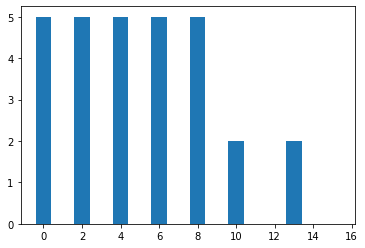

In [14]:
## EXAMPLES

## 5 every second year for 10 years 
values, times, total = lci_t(list_A=[5], list_T=[2], list_D=[10])
print('5 every second year for 10 years')
print('times: ', times)
print('values: ', values)
print('total: ', total)
print('')

## 5 every second year for 10 years, and then 2 every third year for 6 years
values, times, total = lci_t(list_A=[5,2], list_T=[2,3], list_D=[10,6])
print('5 every second year for 10 years, and then 2 every third year for 6 years')
print('times: ', times)
print('values: ', values)
print('total: ', total)
print('')

## two calls combined, for an alternance of values
values1, times, total1 = lci_t(list_A=[2], list_T=[2], list_D=[10])
values2, times, total2 = lci_t(list_A=[0,1], list_T=[1,2], list_D=[1,9])
values3 = values1 + values2
print('alternance of 2 and 1 for 10 years')
print('values: ', values3)


plt.bar(height=values, x = np.array([int(d) for d in np.arange(len(values))]) )


In [12]:
#round-up, kg/ha/yr
values, times, total = lci_t(list_A=[2.43], list_T=[25], list_D=[101])
print('round-up, kg/ha/yr')
print('times: ', times)
print('values: ', values)
print('total: ', total)
print('')

#round-up spraying, MJ/ha/yr
values, times, total = lci_t(list_A=[28.11], list_T=[25], list_D=[101])
print('round-up spraying, MJ/ha/yr')
#print('times: ', times)
print('values: ', values)
print('total: ', total)
print('')

#cougar, kg/ha/yr
values, times, total = lci_t(list_A=[0, 0.6], list_T=[1, 25], list_D=[1, 100])
print('cougar, kg/ha/yr')
#print('times: ', times)
print('values: ', values)
print('total: ', total)
print('')

#cougar spraying, MJ/ha/yr
values, times, total = lci_t(list_A=[0, 28.11], list_T=[1, 25], list_D=[1, 100])
print('cougar spraying, MJ/ha/yr')
#print('times: ', times)
print('values: ', values)
print('total: ', total)
print('')

#weed harvning, MJ/ha/yr
values, times, total = lci_t(list_A=[0, 843.16], list_T=[1, 25], list_D=[1, 100])
print('weed harvning, MJ/ha/yr')
#print('times: ', times)
print('values: ', values)
print('total: ', total)
print('')

round-up, kg/ha/yr
times:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
values:  [2.43 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.43 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   2.43 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   2.43 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   2.43]
total:  12.15

round-up spraying, MJ/ha/yr
values:  [

In [5]:
import numpy as np
a = np.array([24,32])
b = np.array([24,10])
a+b

array([48, 42])